In [2]:
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import gym.wrappers

In [3]:
# Loading the model
MAX_EPISODES = 25000
model_name = f'breakout_alpha_progress_episodes_{MAX_EPISODES}.44'
path = f"./{model_name}"
model = tf.keras.models.load_model(path)

Metal device set to: Apple M1 Max


2022-06-17 19:45:35.491343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-17 19:45:35.491585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
def make_env():
  env = gym.make("BreakoutNoFrameskip-v4", render_mode='human')
  env = wrap_deepmind(env, frame_stack=True, scale=True)
  return env

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]



systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Lost one life after 95 timesteps
{'lives': 4, 'episode_frame_number': 97, 'frame_number': 97}


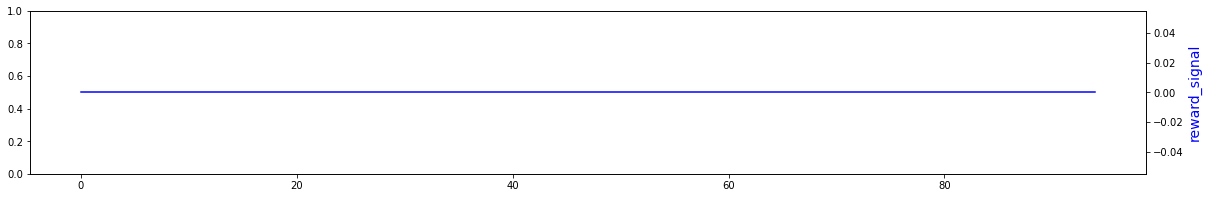

Bricks left to destroy  108.0
Lost one life after 190 timesteps
{'lives': 3, 'episode_frame_number': 195, 'frame_number': 195}


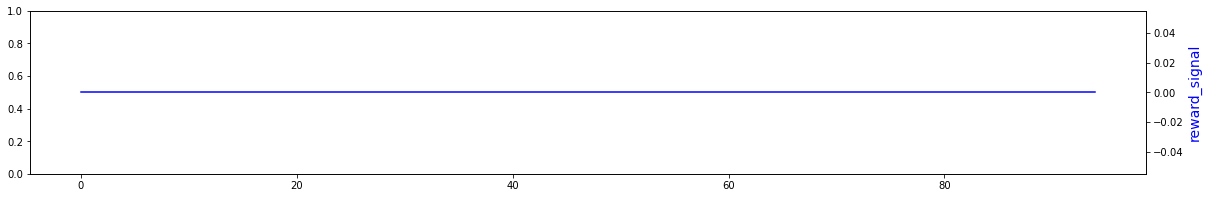

Bricks left to destroy  108.0
Lost one life after 665 timesteps
{'lives': 2, 'episode_frame_number': 673, 'frame_number': 673}


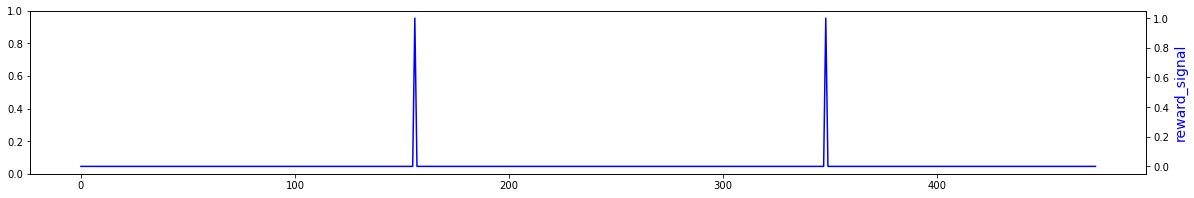

Bricks left to destroy  106.0
Lost one life after 760 timesteps
{'lives': 1, 'episode_frame_number': 771, 'frame_number': 771}


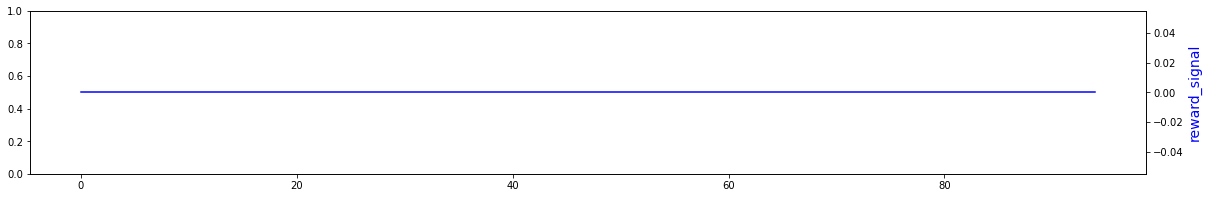

Bricks left to destroy  106.0
Lost one life after 856 timesteps
{'lives': 0, 'episode_frame_number': 869, 'frame_number': 869}


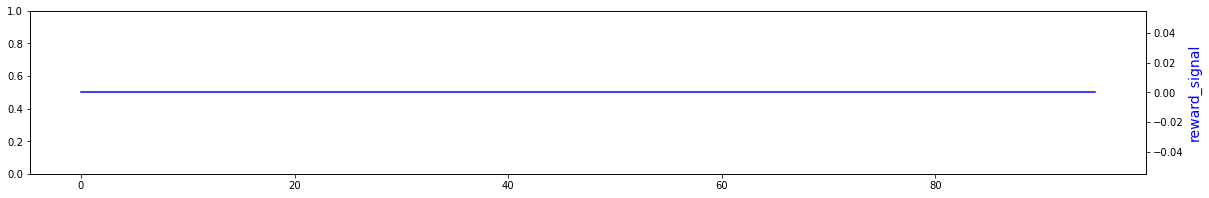

Bricks left to destroy  106.0


In [5]:
env = make_env()
env = gym.wrappers.Monitor(env, "./vid", video_callable=lambda episode_id: True,force=True)

observation = env.reset()
info = 0
reward_window = []
reward_signal_history = []
epsilon_history = []

hits = []
bltd = 108 #total bricks to destroy

timestep = 0

while True:
    state_tensor = tf.convert_to_tensor(observation)
    state_tensor = tf.expand_dims(state_tensor, 0)
    action_probs = model(state_tensor, training=False)
    action = tf.argmax(action_probs[0]).numpy()

    observation, reward, done, info = env.step(action)
    hits.append(reward)
    reward_window.append(reward)
    if len(reward_window) > 200:
      del reward_window[:1] 
    reward_signal_history.append(reward)
    
    timestep += 1


    if done:
        print("Lost one life after {} timesteps".format(timestep))
        print(info)
        fig,ax=plt.subplots(figsize=(20,3))
        ax2=ax.twinx()
        ax2.plot(reward_signal_history,color="blue")
        ax2.set_ylabel("reward_signal",color="blue",fontsize=14)
        plt.show()

        reward_signal_history = []

        bltd = bltd-np.sum(hits)
        hits = []
        print("Bricks left to destroy ", bltd)

        if info['lives'] == 0:
          break

        env.reset()
env.close()